**Домашнее задание**

***Задание 1***: Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/0/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from hmmlearn.hmm import GaussianHMM
import warnings
%matplotlib inline

warnings.filterwarnings(action='once')

Для каждого тома проведем очистку оставив только русские буквы и пробелы, а также преобразуем к нижнему регистру, т.к. он нам не важен.

In [2]:
def read_and_clean(fname):
    with open(fname, "r") as f:
        text = f.read().lower()
    return re.sub("[^а-я ]","", text)
    

vols_count = 4
vols = []
for i in range(vols_count):
    vols.append(read_and_clean(f"war_and_peace/tom_{i + 1}.txt"))

Далее можно либо склеить все тексты в один, либо вычислять матрицу переходных вероятностей суммируя по каждому тому. Разница лишь в том, учитывать переход между томами в расчете вероятностей. Если склеивать в один, тогда не ясно как именно: через пробел или нет. Для простоты выберем вариант без склеивания.

Пронумеруем каждую букву создав словарь. Но сперва убедимся, нужно ли в него добавлять букву "ё".

In [3]:
found = False
for i in range(vols_count):
    pos = vols[i].find("ё")
    if pos != -1:
        found = True
        break
        
if found:
    print("Буква 'ё' найдена.")
else:
    print("Буква 'ё' не найдена.")

Буква 'ё' не найдена.


Теперь составляем словарь.

In [4]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

Рассчитаем матрицу переходных вероятностей.

In [5]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))
for i in range(vols_count):
    for cp, cn in zip(vols[i][:-1], vols[i][1:]):
        probabilities[POS[cp], POS[cn]] += 1
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

Построим тепловую карту матрицы переходных вероятностей.

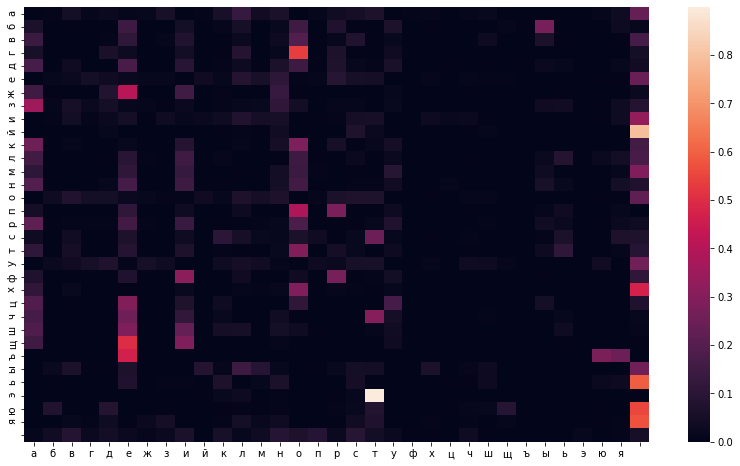

In [6]:
plt.figure(figsize=(14, 8))
sns.heatmap(pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN)))
plt.show()

Довольно интересная матрица получилась. Видно, что после буквы "э" чаще всего встречается буква "т". После "й" чаще всего идет пробел, а после буквы "г" идет буква "о" и т.д.

Посчитаем вероятность встретить строку из 4-х символов, которая начинается "п", а кончается на "р". Выведем также и траектории.

In [7]:
def get_prob(sc, ec, count, lts, proba=1):
    if proba == 0:
        return

    if count == 2:
        proba *= 1.0 / len(RUSSIAN) * probabilities[POS[sc], POS[ec]] # первый и последний компонент
        if proba > 0:
            global tracks, probs
            tracks.append(lts + ec)
            probs.append(proba)
        return
    
    for i, c in enumerate(RUSSIAN):
        get_prob(c, ec, count - 1, lts + c, proba * probabilities[POS[sc], POS[c]]) # промежуточные

        
tracks = []
probs = []
sc = "п"
ec = "р"
le = 4
get_prob(sc, ec, le, sc)
df = pd.DataFrame({"tracks": tracks, "probs": probs})
print(f"Итоговая вероятность: {df['probs'].sum()}.")
print(f"Траектории (первые 20 из {len(df)}):")
df.head(20)

Итоговая вероятность: 0.0009779699840321609.
Траектории (первые 20 из 655):


,tracks,probs
0,паар,1.286129e-08
1,пабр,1.046330e-06
2,павр,1.194306e-06
3,пагр,1.323745e-06
4,падр,3.031260e-06
5,паер,2.009415e-06
6,пажр,7.533524e-09
7,пазр,1.246233e-06
8,паир,2.624997e-08
9,пайр,2.843714e-08


Используя матрицу переходных вероятностей создадим генератор слов указанной длины, начинающихся с заданной буквы.

In [8]:
def get_seq(start, length):
    s = []
    s.append(start)
    for i in range(length - 1):
        index = POS[s[i]]
        next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
        s.append(next_char)
    return ''.join(s)

Сгенерируем несколько последовательностей блины 8 и начинающихся на букву "б".

In [9]:
test_count = 10
letter = "б"
length = 8

for i in range(test_count):
    print(get_seq(letter, length))

ботен ни
бы истос
был фри 
брова эт
быжд что
бето кис
букоелто
безло ст
бея нону
быйчи де


Выглядит довольно странно, но вполне ожидаемо: построено исключительно опираясь на вероятности появления символов друг за другом.

***Задание 2***: Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [10]:
series = pd.read_csv("Series/international-airline-passengers.csv")["Count"]
title = "International Airline Passengers"

В первую очередь посмотрим с чем имеем дело.

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


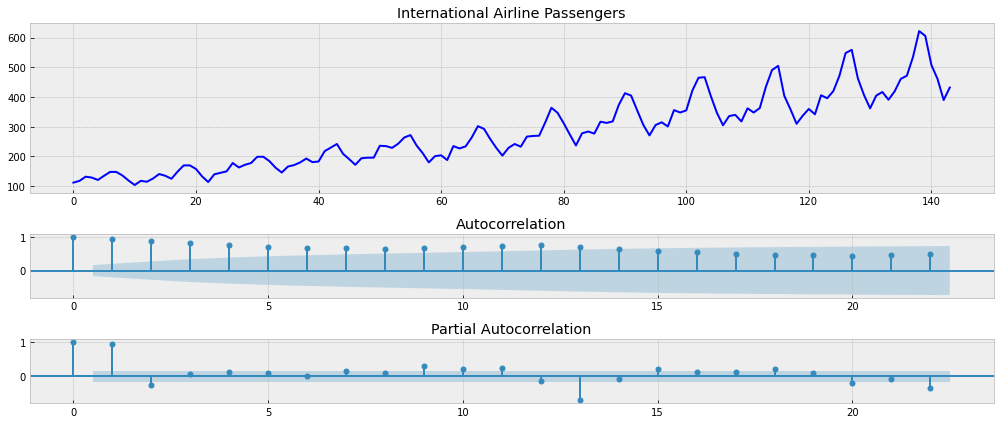

In [11]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 6), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return


tsplot(series, title=title)

Очевидно, что график нестационарный, имеется и тренд и сезонность.

Перед использованием HMM необходимо избавиться от тренда и уменьшить изменение дисперсии. Выполним преобраование Бокса-Кокса и дифференцирование.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
Lags Used                       14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


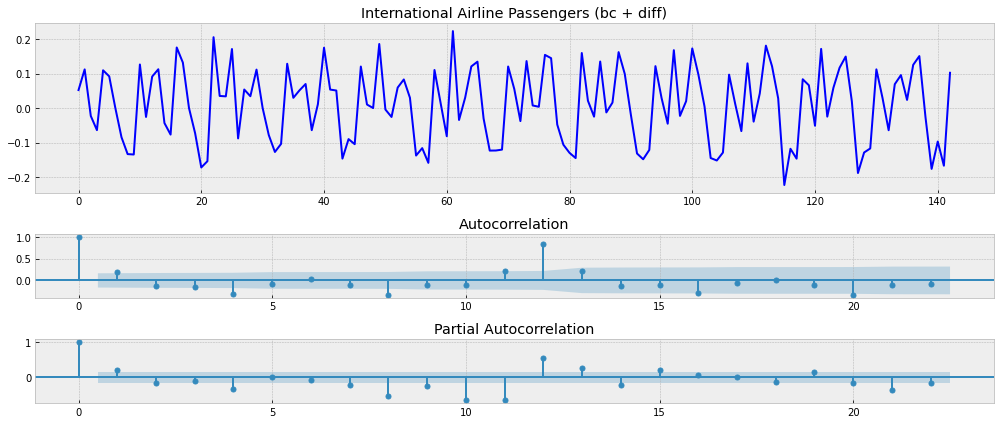

In [12]:
def diff(src):
    return src[1:] - src[:-1]

def undiff(src, offset):
    dst = [offset]
    last = offset
    l = len(src)
    for i in range(l):
        last -= src[l - i - 1]
        dst.append(last)
    return np.array(dst[::-1])

def modify_bc_diff(series):
    series_bc = boxcox(series, 0)
    return diff(series_bc), series_bc[-1]

def unmodify_bc_diff(series, restore_info):
    series_bc = undiff(series, restore_info)
    return inv_boxcox(series_bc, 0)


series_bc_diff, restore_info = modify_bc_diff(series)
tsplot(series_bc_diff, title=title + " (bc + diff)")

Разделим выборку на train и test.

In [13]:
def train_test_split(series, test_val=0.3):
    count = int(len(series) * (1.0 - test_val))
    return series[:count], series[count:]

train, test = train_test_split(series_bc_diff, 0.15)
train_r = train.reshape(-1, 1)
test_r = test.reshape(-1, 1)
#len(series_bc_diff), len(train_r), len(test_r)

Довольно сложно определить сколько должно быть скрытых состояний, поэтому предположим, что у нас их максимум 12 и подберем оптимальное их кол-во.

In [14]:
states = []
scores = []
for i in range(2, 13):
    model = GaussianHMM(n_components=i, n_iter=1000)
    model.fit(train_r)
    score = model.score(train_r)
    states.append(i)
    scores.append(score)
    
results = pd.DataFrame({"states": states, "scores": scores}).set_index("states")
opt = results["scores"].idxmax()
print(f"Наилучшее значение score (логарифма максимального правдоподобия) найдено при {opt} скрытых состояниях.")
results

Fitting a model with 142 free scalar parameters with only 121 data points will result in a degenerate solution.
Fitting a model with 167 free scalar parameters with only 121 data points will result in a degenerate solution.


Наилучшее значение score (логарифма максимального правдоподобия) найдено при 10 скрытых состояниях.


,scores
states,
2,119.239755
3,142.848869
4,170.253122
5,170.105491
6,170.254469
7,188.293644
8,178.073053
9,178.073225
10,195.874099


Теперь с наилучшим значением построим модель и выведем график на тренировочных данных и на тестовых.

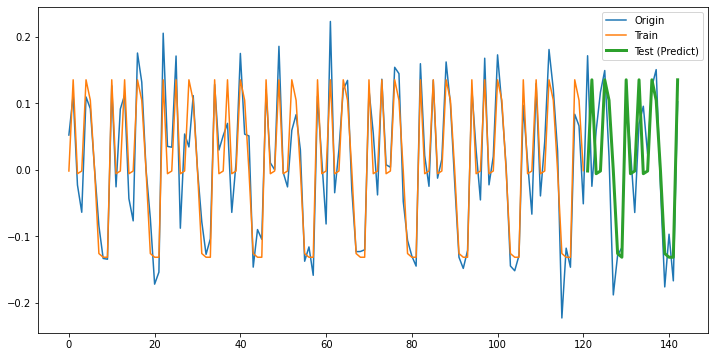

In [15]:
def get_means(model, series):
    labels = model.predict(series)
    means = np.zeros_like(series)
    for i in range(model.n_components):
        means[labels == i] = model.means_[i]
    return means

model = GaussianHMM(n_components=opt, n_iter=1000)
model.fit(train_r)

means_tr = get_means(model, train_r)
means_ts = get_means(model, test_r)
    
plt.figure(figsize=(12, 6))
plt.plot(series_bc_diff)
plt.plot(means_tr)
plt.plot([i for i in range(len(train), len(series_bc_diff))], means_ts, linewidth=3)
plt.legend(["Origin", "Train", "Test (Predict)"])
plt.show()

Получилась не идеальная, но довольно неплохое описание, а также прогноз. Кроме того, модель еще можно оптимизировать, задавая априорное распределения с помощью спецификации model.transmat_, кол-во итераций для градиентного спуска и др. параметры.

Отобразим исходный ряд и наложим на него результаты работы модели.

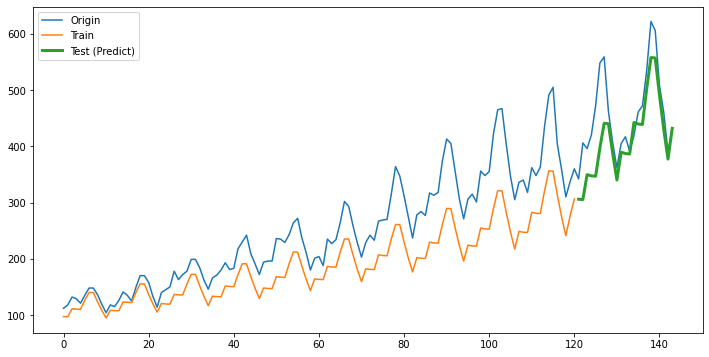

In [16]:
full = np.append(means_tr, means_ts)
full_restored = unmodify_bc_diff(full, restore_info)

plt.figure(figsize=(12, 6))
plt.plot(series)
plt.plot(full_restored[:len(train)])
plt.plot([i for i in range(len(train), len(series))], full_restored[len(train):], linewidth=3)
plt.legend(["Origin", "Train", "Test (Predict)"])
plt.show()

Заметно, что график после применения обратного дифференцирования и обратного преобразования Бокса-Кокса несколько отстает по амлитуде от исходного, но довольно неплохо повторяет форму. Отставание по амплитуде есть и на предыдущем графике. Кроме того, возможно, стоит тщательнее подобрать последнее значение ряда (смещение), от которого выполняется обратное дифференцирование.